# Vegetable Classifier
We will create a Convolution Neural Network model which will classify type of vegetable from given images. We will train it to identify from 15 different vegetables -> [Bean, Bitter_Gourd, Bottle_Gourd, Brinjal, Broccoli, Cabbage, Capsicum, Carrot, Cauliflower, Cucumber, Papaya, Potato, Pumpkin, Radish, Tomato]

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr

#### Importing dataset

In [ ]:
import os
import subprocess
import zipfile

# Setting path for Kaggle API key
# os.environ["KAGGLE_CONFIG_DIR"] = os.getcwd()  # Set current directory
os.environ["KAGGLE_CONFIG_DIR"] = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define dataset paths
zip_path = os.path.join(os.getcwd(), "vegetable-image-dataset.zip")
dataset_path = os.path.join(os.getcwd(), "Vegetable_Images")


# Define dataset paths
zip_path = "vegetable-image-dataset.zip"
dataset_path = "Vegetable_Images"

# Check if dataset is already extracted
if not os.path.exists(dataset_path):
   if not os.path.exists(zip_path):
      print("📥 Downloading dataset from Kaggle...")
      try:
         subprocess.run(["kaggle", "datasets", "download", "-d", "misrakahmed/vegetable-image-dataset"], check=True)
      except subprocess.CalledProcessError as e:
         print("❌ Error downloading dataset:", e)
         exit(1)  # Exit if download fails
         
   # Extract dataset
   print("📂 Extracting dataset...")
   with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(os.getcwd())
   
   print("✅ Dataset extracted successfully.")
else:
   print(f"📁 Dataset already found at: {dataset_path}")

📂 Extracting dataset...
✅ Dataset extracted successfully.


In [ ]:
# import os
# import zipfile
# import subprocess

# # Ensure kaggle.json is in the right place
# if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
#    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
#    if os.path.exists("kaggle.json"):
#       os.replace("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
#       print("✅ Kaggle API key moved to ~/.kaggle/")
#    else:
#       raise FileNotFoundError("❌ kaggle.json not found! Upload it to the project directory.")

# # Set correct permissions for security
# os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# # Define dataset paths
# zip_path = "vegetable-image-dataset.zip"
# dataset_path = "Vegetable_Images"

# # Check if dataset is already extracted
# if not os.path.exists(dataset_path):
#    if not os.path.exists(zip_path):
#       print("📥 Downloading dataset from Kaggle...")
#       try:
#          subprocess.run(["kaggle", "datasets", "download", "-d", "misrakahmed/vegetable-image-dataset"], check=True)
#       except subprocess.CalledProcessError as e:
#          print("❌ Error downloading dataset:", e)
#          exit(1)  # Exit if download fails

#    # Extract dataset
#    print("📂 Extracting dataset...")
#    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#       zip_ref.extractall(os.getcwd())

#    print("✅ Dataset extracted successfully.")
# else:
#    print(f"📁 Dataset already found at: {dataset_path}")


Loading dataset from generators

In [3]:
# Generators
training_ds = kr.utils.image_dataset_from_directory(
   directory='Vegetable Images/train',
   labels='inferred',
   label_mode='int',
   batch_size=80,
   image_size=(256, 256)
)

validation_ds = kr.utils.image_dataset_from_directory(
   directory='Vegetable Images/validation',
   labels='inferred',
   label_mode='int',
   batch_size=80,
   image_size=(256, 256)
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [4]:
from collections import Counter

# Get class names
class_names = [name for name in training_ds.class_names if not name.startswith('.')]

# Efficiently count occurrences of each label
all_labels = np.concatenate([label.numpy() for _, label in training_ds])
class_count = Counter(all_labels)

# Print class distribution
print("Class distribution in training set:")
for idx, count in sorted(class_count.items()):
   print(f"{class_names[idx]}: {count}")

Class distribution in training set:
Bean: 1000
Bitter_Gourd: 1000
Bottle_Gourd: 1000
Brinjal: 1000
Broccoli: 1000
Cabbage: 1000
Capsicum: 1000
Carrot: 1000
Cauliflower: 1000
Cucumber: 1000
Papaya: 1000
Potato: 1000
Pumpkin: 1000
Radish: 1000
Tomato: 1000


In [5]:
## Normalize
def normalize(image, label):
   image = tf.cast(image/255. ,tf.float32)
   return image, label

training_ds = training_ds.map(normalize)
validation_ds = validation_ds.map(normalize)

### Plotting First image from each class

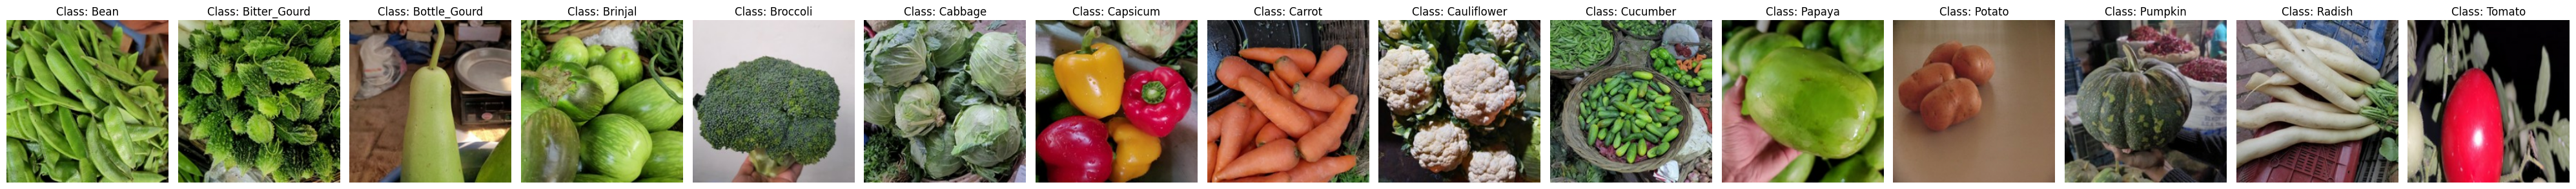

In [6]:
# Get the first batch of images and labels from the training dataset
images, labels = next(iter(training_ds))
labels = labels.numpy()

# Create a figure and axes for the plot
fig, axes = plt.subplots(nrows=1, ncols=len(class_names), figsize=(40, 12))

# Iterate over the class names
for i, class_name in enumerate(class_names):
   # Index of the first image belonging to the current class
   index = np.where(labels == i)[0][0]
   
   # Plot the image
   axes[i].imshow(images[index].numpy())
   axes[i].set_title(f"Class: {class_name}")
   axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
# Create the labels dictionary using class_names
labels = {i: class_name for i, class_name in enumerate(class_names)}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
   print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Bean
1 : Bitter_Gourd
2 : Bottle_Gourd
3 : Brinjal
4 : Broccoli
5 : Cabbage
6 : Capsicum
7 : Carrot
8 : Cauliflower
9 : Cucumber
10 : Papaya
11 : Potato
12 : Pumpkin
13 : Radish
14 : Tomato


Creating CNN model:

In [8]:
model = kr.Sequential()
## Input layers
model.add(kr.layers.Input(shape=(256, 256, 3)))

## Convolution layers
model.add(kr.layers.Conv2D(32, kernel_size=(5,5), padding='valid',))
model.add(kr.layers.LeakyReLU(negative_slope=0.1))
model.add(kr.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(kr.layers.BatchNormalization())

model.add(kr.layers.Conv2D(32, kernel_size=(5,5), padding='valid',))
model.add(kr.layers.LeakyReLU(negative_slope=0.1))
model.add(kr.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(kr.layers.BatchNormalization())

model.add(kr.layers.Conv2D(16, kernel_size=(5,5), padding='valid',))
model.add(kr.layers.LeakyReLU(negative_slope=0.1))
model.add(kr.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(kr.layers.BatchNormalization())

model.add(kr.layers.Flatten()) ## Flattening layer

## Fully connected layers
model.add(kr.layers.Dense(128, activation='relu'))
model.add(kr.layers.Dropout(0.3))
model.add(kr.layers.Dense(64, activation='relu'))
model.add(kr.layers.Dropout(0.2))
model.add(kr.layers.Dense(15, activation='softmax'))

c:\D Drive\coding\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,867,647 (7.12 MB)

 Trainable params: 1,867,487 (7.12 MB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
## setting the callback
callback = kr.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10,
   verbose=1, mode="auto", baseline=None, restore_best_weights=True)

lr_callback = kr.callbacks.ReduceLROnPlateau(
   monitor='val_loss', factor=0.5, patience=3,
   verbose=1, min_lr=1e-6, min_delta = 1e-4
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_ds, epochs=20,verbose=1, validation_data=validation_ds, callbacks=[callback, lr_callback])

Epoch 1/5
  4/188 ━━━━━━━━━━━━━━━━━━━━ 2:04:26 41s/step - accuracy: 0.1221 - loss: 3.6338

> We are able to get an accuracy above 95% which is better then a humans.

#### Plotting accuracy and Loss function:

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.ylabel('Accuracy: ')
plt.xlabel('Epochs')

plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.ylabel('Loss Function')
plt.xlabel('Epochs')

plt.legend()
plt.grid()
plt.show()

#### Model Evaluation:

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import keras_tuner as kt

# Load the testing dataset
test_ds = kr.utils.image_dataset_from_directory(
   directory='Vegetable Images/test',
   labels='inferred',
   label_mode='int',
   batch_size=80,
   image_size=(256, 256)
)

# Normalize test dataset
test_ds = test_ds.map(normalize)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Get predictions
y_true, y_pred = [], []
for images, labels in test_ds:
   preds = model.predict(images)
   y_true.extend(labels.numpy())
   y_pred.extend(np.argmax(preds, axis=1))

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))